In [12]:
# Crypto_Module importation #

from crypto_module import *
from statsmodels.graphics.tsaplots import pacf, acf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import kpss 
import statsmodels.api as sm
import pmdarima as pm
import arima_module

In [10]:
# Use the API to load the data #

symbol = 'BTC/USD'
interval = '1day'
start_date = '2018-01-01 00:00:00'
end_date = '2020-12-31 00:00:00'

In [11]:
# Checking the data values #

data = load_data(symbol, start_date, end_date, interval)
data['log_close'] = np.log(data['close'])
data.head(n = 10)

,datetime,open,high,low,close,log_close
0,2018-01-01,14112.20020,14112.20020,13154.70020,13657.20020,9.522022
1,2018-01-02,13625.00000,15444.59961,13163.59961,14982.09961,9.614611
2,2018-01-03,14978.20020,15572.79980,14844.50000,15201.00000,9.629116
3,2018-01-04,15270.70020,15739.70020,14522.20020,15599.20020,9.654975
4,2018-01-05,15477.20020,17705.19922,15202.79980,17429.50000,9.765919
5,2018-01-06,17462.09961,17712.40039,16764.59961,17527.00000,9.771498
6,2018-01-07,17527.30078,17579.59961,16087.70020,16477.59961,9.709757
7,2018-01-08,16476.19922,16537.90039,14208.20020,15170.09961,9.627082
8,2018-01-09,15123.70020,15497.50000,14424.00000,14595.40039,9.588462
9,2018-01-10,14588.50000,14973.29980,13691.20020,14973.29980,9.614024


In [6]:
#


NameError: name 'statsmodels' is not defined

#### Before applying the ARIMA prediction model, we need to check if the series is stationnary
###### For this sake, we first plot the moving average and standard deviation on the last 14 days
###### We need them to be approximately constant in time.
###### Then we run the ADF test on the time series. 
###### We want the ADF statistic of the time series to be as close as possible to the criticals values returned by the test and its p-value to be small 

In [13]:
arima_module.stationnarity_fast_check(data, close, 14)

NameError: name 'close' is not defined

#### Observations

###### While the standard deviation gives us hope about being constant, the rolling mean seems pretty much instable
###### The ADF test results shows that the series is pretty far from being stationnary

##### To lower the variation width we can focus of the log of the close cotation and see the results on this new series 


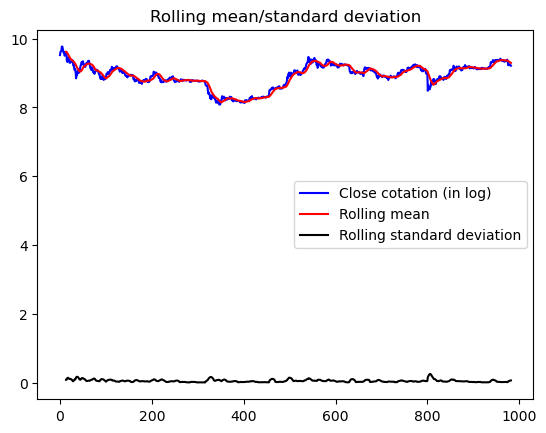

ADF statistics : -2.3667527195738494
p-value : 0.15134087720706035
Critical values :
	1%: -3.4370403176323214
	5%: -2.8644937368358425
	10%: -2.5683427207413576


In [5]:
period = 14
rolling_mean = np.log(data['close']).rolling(window=period).mean()
rolling_std = np.log(data['close']).rolling(window=period).std()
    
# Plot comparing time series and its moving statistics
original = plt.plot(np.log(data['close']), color='blue', label='Close cotation (in log)')
mean = plt.plot(rolling_mean, color='red', label='Rolling mean')
std = plt.plot(rolling_std, color='black', label='Rolling standard deviation')
plt.legend(loc='best')
plt.title('Rolling mean/standard deviation')
plt.show(block=False)
        
# Dickey–Fuller's Test :
result = adfuller(np.log(data['close']))
print('ADF statistics : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))




##### The log transformatiion makes the stationnarity hypothesis much more plausible at sight and the ADF tests results looks corrects as though the p-value is worst than without the log  

##### We will try a third approach wich consists in substracting the rolling mean to the close cotation value and only focus on deviations around this value. 

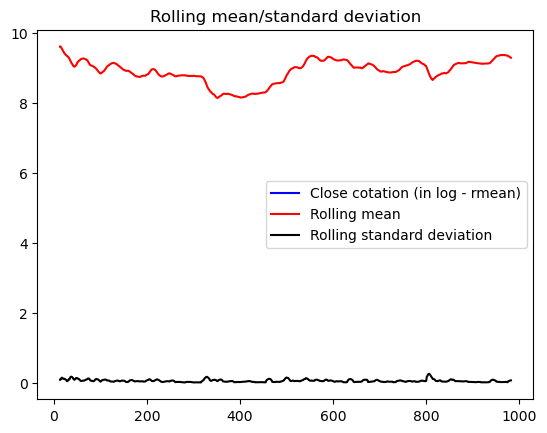

MissingDataError: exog contains inf or nans

In [8]:
period = 14
rolling_mean = np.log(data['close']).rolling(window=period).mean()
data['centered_log_close'] = (np.log(data['close'])-rolling_mean).dropna(inplace=True)
rolling_std = np.log(data['close']).rolling(window=period).std()
    
# Plot comparing time series and its moving statistics
original = plt.plot(data['centered_log_close'], color='blue', label='Close cotation (in log - rmean)')
mean = plt.plot(rolling_mean, color='red', label='Rolling mean')
std = plt.plot(rolling_std, color='black', label='Rolling standard deviation')
plt.legend(loc='best')
plt.title('Rolling mean/standard deviation')
plt.show(block=False)

# Dickey–Fuller's Test :
result = adfuller(data['centered_log_close'])
print('ADF statistics : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value)) 





##### This approach does not upgrade the results we obtain with the log transformation 
##### We will stick at applying the ARIMA prediction model on to the log of the close cotation

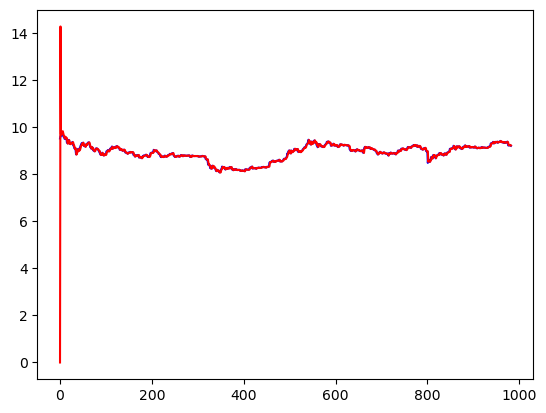

In [15]:
from statsmodels.tsa.arima.model import ARIMA
data['log_close'] = np.log(data['close'])
model = ARIMA(data['log_close'], order=(2,2,1))
results = model.fit()
plt.plot(data['log_close'], color = 'blue')
plt.plot(results.fittedvalues, color='red')

In [7]:
from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(data['log_close'], order=(2,2,1))
model_fit = model.fit()
model_fit

                               SARIMAX Results                                
Dep. Variable:                   high   No. Observations:                  983
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -7034.402
Date:                Thu, 07 Dec 2023   AIC                          14072.803
Time:                        10:09:23   BIC                          14082.583
Sample:                             0   HQIC                         14076.523
                                - 983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1517      0.020      7.624      0.000       0.113       0.191
sigma2      9.801e+04   2000.973     48.980      0.000    9.41e+04    1.02e+05
Ljung-Box (L1) (Q):                   0.38   Jarque-

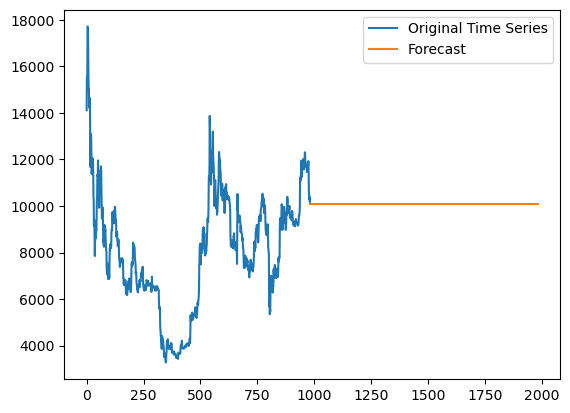

In [32]:
# Convertir la colonne log_close en série temporelle si ce n'est pas déjà le cas


#time_series = pd.Series(data['log_close'].values, index=data['date_column'])

# Si votre série temporelle est déjà une Time Series, vous pouvez directement utiliser la ligne suivante
# time_series = data['log_close']

# Créer le modèle ARIMA
ordre = (0, 1, 1)  
model = ARIMA(data['high'],exog = None, order=ordre)

result = model.fit()
print(result.summary())

# Prévoir les valeurs futures
forecast_steps = 1000  # Remplacez 10 par le nombre d'étapes que vous souhaitez prévoir
forecast = result.forecast(steps=forecast_steps)

# Afficher le résultat
print(forecast)

# Tracer la série temporelle originale et les prévisions
plt.plot(data['high'], label='Original Time Series')
plt.plot(range(len(data['high']), len(data['high']) + forecast_steps), forecast, label='Forecast')
plt.legend()
plt.show()


In [31]:
from pmdarima import auto_arima

model = auto_arima(data['high'], seasonal=False, suppress_warnings=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  983
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -7034.402
Date:                Thu, 07 Dec 2023   AIC                          14072.803
Time:                        10:08:47   BIC                          14082.583
Sample:                             0   HQIC                         14076.523
                                - 983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1517      0.020      7.624      0.000       0.113       0.191
sigma2      9.801e+04   2000.973     48.980      0.000    9.41e+04    1.02e+05
Ljung-Box (L1) (Q):                   0.38   Jarque-